<a href="https://colab.research.google.com/github/AroojArifNU/DLTest/blob/main/DLTest%20/Colab_Notebooks/cgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Check GPU

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: nvidia-smi: command not found


# 2. Import Dependencies

In [3]:
!pip install -q wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.3 MB/s eta 0:00:00


In [4]:
# For general usage
import numpy as np
import tensorflow as tf

# For dataset
import tensorflow_datasets as tfds

# For models
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, Embedding, Input, Concatenate, Conv2DTranspose

# For callback
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

# For streamlining ML workflow
import wandb
from wandb.keras import WandbCallback

# For model memory usage
from tensorflow.keras import backend as K
import humanize

# For visualisation
from matplotlib import pyplot as plt

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 3. Load the dataset

In [14]:
# Name of the used dataset
DATASET_NAME = "mnist"

# Shape of the input image
INPUT_SHAPE = (28,28,1)

# Dimension of latent vector
LATENT_VECTOR_DIM = 100

# Number of classes
N_CLASSES = 10

# Number of images in dataset
N_IMAGES = 60000

# Batch size
BATCH_SIZE = 128

# Number of batches that can be formed from a given dataset size
N_BATCHES = N_IMAGES // BATCH_SIZE

# Number of epochs
N_EPOCHS = 2000

# Name of the project for Weights and Biases platform
WB_PROJECT = "GAN"

# Entity (login) for Weights and Biases platform
WB_ENTITY = "matusstas"

In [15]:
def preprocess_images(data):
    """ Normalize images to 0-1"""
    image = data['image']
    label = data['label']
    return image / 255, label

def load_dataset():
    """ Load and prepare the dataset """
    # Load the dataset
    dataset = tfds.load(DATASET_NAME, split='train')

    # Take only selected amount of images
    dataset = dataset.take(N_BATCHES * BATCH_SIZE)

    # Preproces images
    dataset = dataset.map(preprocess_images)

    # Cache the dataset for that batch
    dataset = dataset.cache()

    # Shuffle it up
    dataset = dataset.shuffle(N_BATCHES * BATCH_SIZE)

    # Create batches
    dataset = dataset.batch(BATCH_SIZE)

    # Reduces the likelihood of bottlenecking
    dataset = dataset.prefetch(BATCH_SIZE // 2)
    return dataset

dataset = load_dataset()

print(f"shape of the images: {dataset.as_numpy_iterator().next()[0].shape}")
print(f"shape of the labels: {dataset.as_numpy_iterator().next()[1].shape}")

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
shape of the images: (128, 28, 28, 1)
shape of the labels: (128,)


# 4. Build models



## Helper function to calculate model memory usage

In [16]:
def get_model_usage(model):
    """
    Get memory usage of the model with chosen batch size

    modified function from this link: https://stackoverflow.com/questions/43137288/how-to-determine-needed-memory-of-keras-model
    """
    count_shapes_mem = 0
    count_internal_model_mem = 0

    for layer in model.layers:
        layer_type = layer.__class__.__name__

        if layer_type == "Model":
            count_internal_model_mem += get_model_usage(BATCH_SIZE, layer)

        single_layer_mem = 1
        out_shape = layer.output_shape
        out_shape = out_shape[0] if type(out_shape) is list else out_shape

        for shape in out_shape:
            if shape is None:
                continue
            single_layer_mem *= shape
        count_shapes_mem += single_layer_mem

    count_trainable = np.sum([K.count_params(p) for p in model.trainable_weights])
    count_non_trainable = np.sum([K.count_params(p) for p in model.non_trainable_weights])

    # Choose correct precision of floating-point numbers
    precisions = {"float16": 2.0, "float32": 4.0, "float64": 8.0}
    number_size = precisions[K.floatx()]

    total_memory = number_size * (BATCH_SIZE * count_shapes_mem + count_trainable + count_non_trainable)
    total_memory = humanize.naturalsize(total_memory + count_internal_model_mem, binary=True)
    print(f"Total memory usage with batch size of {BATCH_SIZE} is: {total_memory}")

## Build generator

In [17]:
def build_generator():
    """ Build model of the generator using functional API """
    input_label = Input(shape=(1,))
    l = Embedding(N_CLASSES, 50)(input_label)
    l = Dense(7*7)(l)
    l = Reshape((7,7,1))(l)

    input_latent_vector = Input(shape=(LATENT_VECTOR_DIM,))
    lv = Dense(7*7*128)(input_latent_vector)
    lv = LeakyReLU(alpha=0.2)(lv)
    lv = Reshape((7, 7, 128))(lv)

    x = Concatenate()([lv, l])

    x = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)

    output = Conv2D(1, (8,8), activation='sigmoid', padding='same')(x)
    model = Model([input_latent_vector, input_label], output)
    return model

In [18]:
generator = build_generator()

In [19]:
get_model_usage(generator)

Total memory usage with batch size of 128 is: 139.7 MiB


In [20]:
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 dense_1 (Dense)             (None, 6272)                 633472    ['input_3[0][0]']             
                                                                                                  
 embedding (Embedding)       (None, 1, 50)                500       ['input_2[0][0]']             
                                                                                              

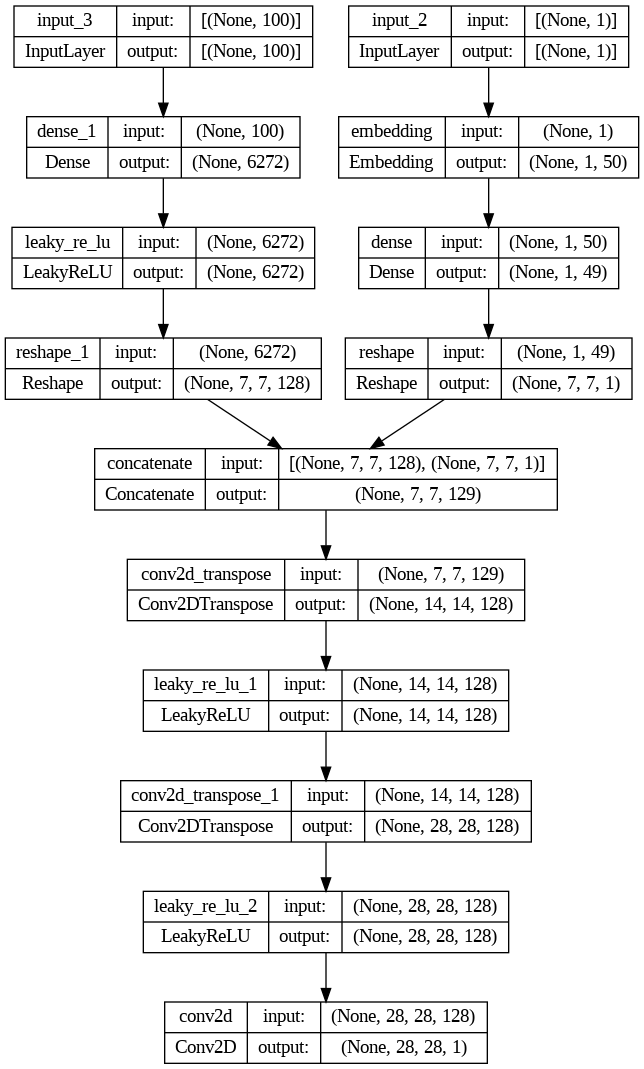

In [21]:
tf.keras.utils.plot_model(generator, show_shapes=True)

## Build discriminator

In [22]:
def build_discriminator():
    """ Build model of the generator using functional API """
    input_label = Input(shape=(1,))
    l = Embedding(N_CLASSES, 50)(input_label)
    l = Dense(INPUT_SHAPE[0] * INPUT_SHAPE[1])(l)
    l = Reshape((INPUT_SHAPE[0], INPUT_SHAPE[1], 1))(l)

    input_image = Input(shape=INPUT_SHAPE)
    x = Concatenate()([input_image, l])

    x = Conv2D(128, (3,3), strides=(2,2), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(128, (3,3), strides=(2,2), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Flatten()(x)
    x = Dropout(0.4)(x)

    output = Dense(1, activation='sigmoid')(x)

    model = Model([input_image, input_label], output)
    return model

In [23]:
discriminator = build_discriminator()

In [24]:
get_model_usage(discriminator)

Total memory usage with batch size of 128 is: 39.4 MiB


In [25]:
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 50)                500       ['input_4[0][0]']             
                                                                                                  
 dense_2 (Dense)             (None, 1, 784)               39984     ['embedding_1[0][0]']         
                                                                                                  
 input_5 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                            

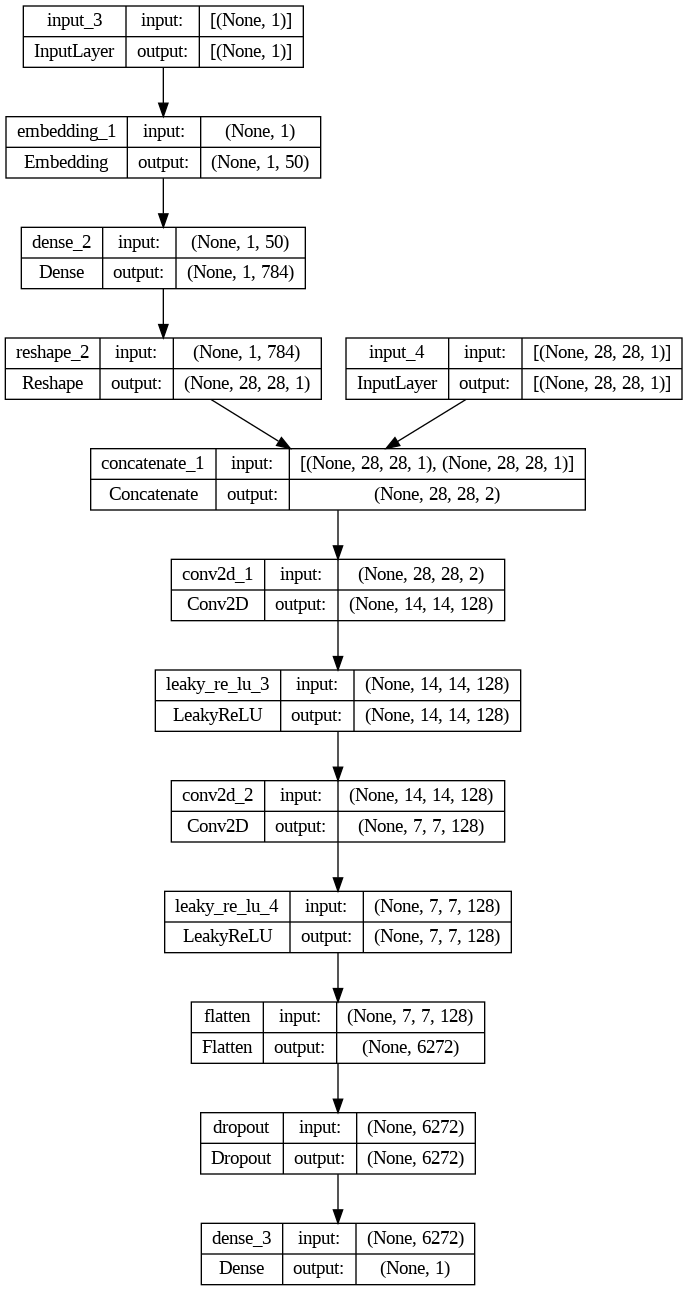

In [ ]:
tf.keras.utils.plot_model(discriminator, show_shapes=True)

# Build GAN

In [26]:
class GAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class
        super().__init__(*args, **kwargs)

        # Create attributes for gen and disc
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, opt_g, opt_d, loss_g, loss_d, *args, **kwargs):
        # Compile with base class
        super().compile(*args, **kwargs)

        # Create attributes for losses and optimizers
        self.opt_g = opt_g
        self.opt_d = opt_d
        self.loss_g = loss_g
        self.loss_d = loss_d

    @tf.function
    def train_step(self, batch):
        # Get the data
        images_real, labels = batch
        labels = tf.expand_dims(labels, axis=-1)

        # Generate images
        latent_vectors = tf.random.normal(shape=(BATCH_SIZE, LATENT_VECTOR_DIM))
        images_generated = self.generator([latent_vectors, labels], training=False)

        # Train the discriminator
        with tf.GradientTape() as d_tape:
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator([images_real, labels], training=True)
            yhat_fake = self.discriminator([images_generated, labels], training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

            # Add some noise to the TRUE outputs (crucial step)
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            # Calculate loss
            total_loss_d = self.loss_d(y_realfake, yhat_realfake)

        # Apply backpropagation
        dgrad = d_tape.gradient(total_loss_d, self.discriminator.trainable_variables)
        self.opt_d.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Train the generator
        with tf.GradientTape() as g_tape:
            # Generate images
            latent_vectors = tf.random.normal(shape=(BATCH_SIZE, LATENT_VECTOR_DIM))
            images_generated = self.generator([latent_vectors, labels], training=True)

            # Create the predicted labels
            predicted_labels = self.discriminator([images_generated, labels], training=False)

            # Calculate loss - trick to training to fake out the discriminator
            total_loss_g = self.loss_g(tf.zeros_like(predicted_labels), predicted_labels)

        # Apply backpropagation
        ggrad = g_tape.gradient(total_loss_g, self.generator.trainable_variables)
        self.opt_g.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"loss_d":total_loss_d, "loss_g":total_loss_g}

# Build Monitoring callback



In [27]:
class ModelMonitor(Callback):
    def __init__(self, n_images=10, latent_dim=LATENT_VECTOR_DIM):
        # Create attributes
        self.n_images = n_images
        self.latent_dim = LATENT_VECTOR_DIM

    def on_epoch_end(self, epoch, logs=None):
      """
      After every 10 iterations generate all digits from 0 to 9 and log them
      into Weights % Biases platform
      """
      if epoch % 10 == 0:
        labels = np.arange(0, N_CLASSES)
        labels = np.expand_dims(labels, axis=-1)

        latent_vectors = tf.random.normal(shape=(10, LATENT_VECTOR_DIM))
        images_generated = generator([latent_vectors, labels])
        images_generated *= 255

        for i in range(self.n_images):
            img = array_to_img(images_generated[i])
            wandb.log({f"number {i}": wandb.Image(img)})

# 5. Train model

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
run = wandb.init(WB_PROJECT="GAN", WB_ENTITY="matusstas")

# Initialize optimizers# Initialize losses# Initialize models
opt_g = Adam(learning_rate=0.0001, beta_1=0.5)
opt_d = Adam(learning_rate=0.00001, beta_1=0.5)

# Initialize losses
loss_g = BinaryCrossentropy()
loss_d = BinaryCrossentropy()

# Initialize models
generator = build_generator()
discriminator = build_discriminator()
gan = GAN(generator, discriminator)
gan.compile(opt_g, opt_d, loss_g, loss_d)

callbacks=[
    ModelMonitor(),
    WandbCallback()
]

history = gan.fit(dataset, epochs=N_EPOCHS, callbacks=callbacks)

wandb.run.finish()

# 6. Evaluate model

4/4 [==============================] - 1s 188ms/step


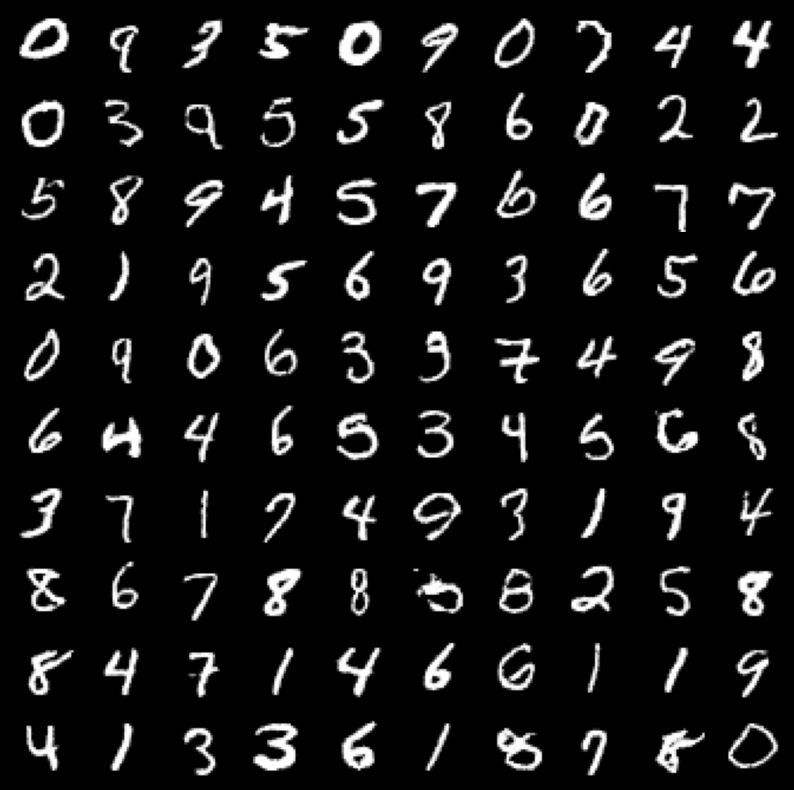

In [31]:


N_SAMPLES = 10
FIG_SIZE = 10

# Generate labels
labels = np.random.randint(N_CLASSES, size=N_SAMPLES*N_SAMPLES)
labels = np.expand_dims(labels, axis=-1)

# Generate images
latent_vectors = tf.random.normal(shape=(N_SAMPLES*N_SAMPLES, LATENT_VECTOR_DIM))
images_generated = gan.generator.predict([latent_vectors, labels])
images_generated = images_generated.reshape(N_SAMPLES, N_SAMPLES, INPUT_SHAPE[0], INPUT_SHAPE[1])

# Prepare subplots
fig, ax = plt.subplots(nrows=N_SAMPLES, ncols=N_SAMPLES, figsize=(FIG_SIZE, FIG_SIZE))

# Change face color of the plot to black
fig.patch.set_facecolor('xkcd:black')
for i in range(N_SAMPLES):
  for j in range(N_SAMPLES):
    img = np.squeeze(images_generated[i][j])
    ax[i][j].imshow(img, cmap='gray')
    ax[i][j].axis('off')

# fig.savefig('output.png', dpi=300)

# 7. Save model's weights

In [ ]:
gan.save_weights('./checkpoints/my_checkpoint')

# 8. Load model's weights

In order to load weights, model has to be compiled

In [8]:
generator = load_model('/content/drive/MyDrive/Colab Notebooks/cGAN-main/cgan.h5')

In [28]:
# Initialize optimizers
opt_g = Adam(learning_rate=0.0001, beta_1=0.5)
opt_d = Adam(learning_rate=0.00001, beta_1=0.5)

# Initialize losses
loss_g = BinaryCrossentropy()
loss_d = BinaryCrossentropy()

# Initialize models
generator = build_generator()
discriminator = build_discriminator()
gan = GAN(generator, discriminator)
gan.compile(opt_g, opt_d, loss_g, loss_d)

gan.load_weights("/content/drive/MyDrive/Colab Notebooks/cGAN-main/checkpoints/my_checkpoint")

4/4 [==============================] - 1s 123ms/step


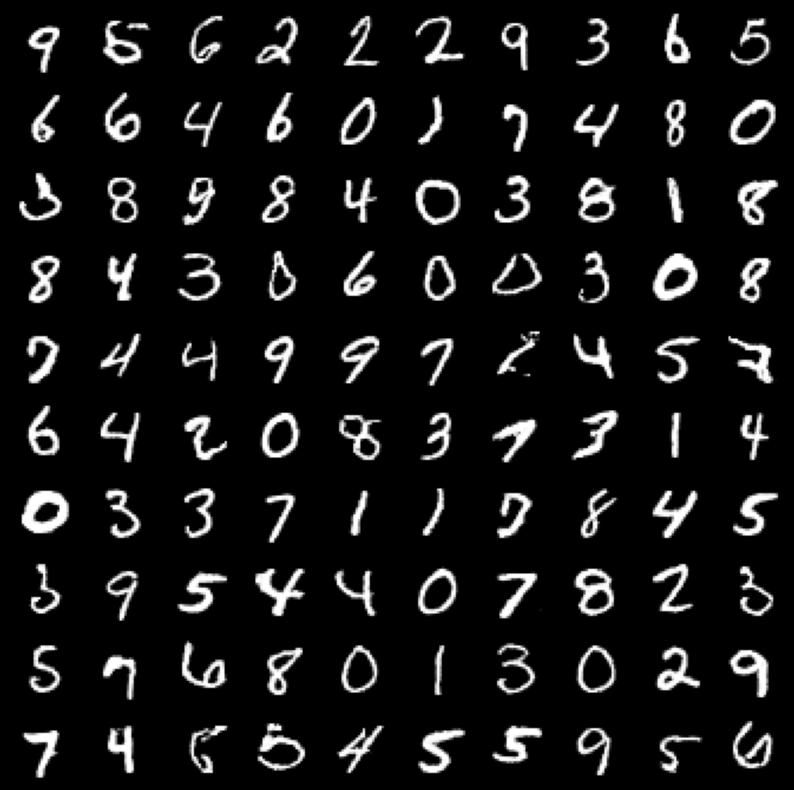

In [32]:
N_SAMPLES = 10
FIG_SIZE = 10

# Generate labels
labels = np.random.randint(N_CLASSES, size=N_SAMPLES*N_SAMPLES)
labels = np.expand_dims(labels, axis=-1)

# Generate images
latent_vectors = tf.random.normal(shape=(N_SAMPLES*N_SAMPLES, LATENT_VECTOR_DIM))
images_generated = gan.generator.predict([latent_vectors, labels])
images_generated = images_generated.reshape(N_SAMPLES, N_SAMPLES, INPUT_SHAPE[0], INPUT_SHAPE[1])

# Prepare subplots
fig, ax = plt.subplots(nrows=N_SAMPLES, ncols=N_SAMPLES, figsize=(FIG_SIZE, FIG_SIZE))

# Change face color of the plot to black
fig.patch.set_facecolor('xkcd:black')
for i in range(N_SAMPLES):
  for j in range(N_SAMPLES):
    img = np.squeeze(images_generated[i][j])
    ax[i][j].imshow(img, cmap='gray')
    ax[i][j].axis('off')

# fig.savefig('output.png', dpi=300)

4/4 [==============================] - 2s 308ms/step


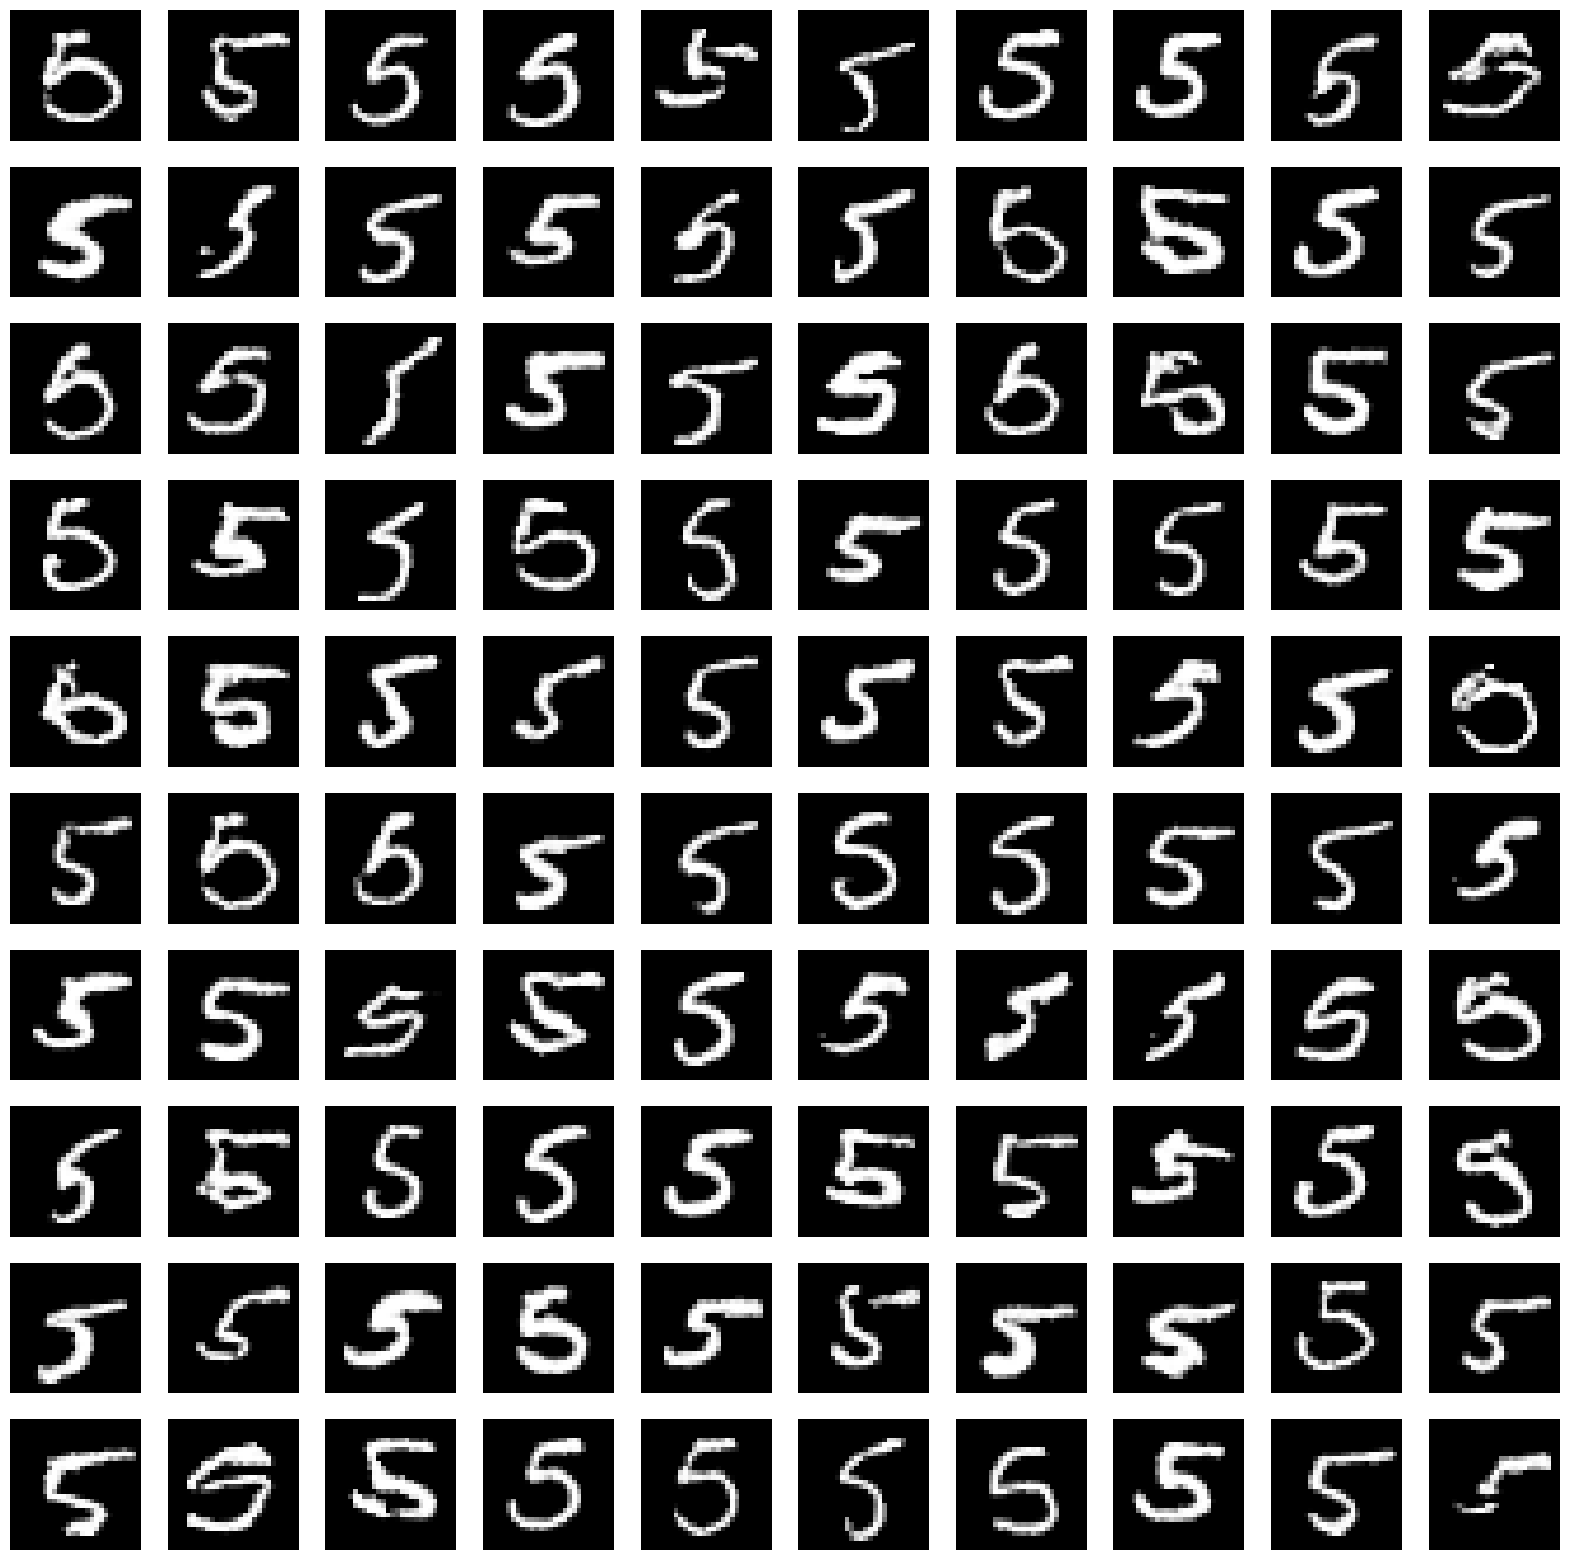

In [48]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

# Constants for generation
N_SAMPLES_TOTAL = 100  # Total number of samples you want to generate
N_SAMPLES_PER_ROW = 10  # Number of samples per row
TARGET_CLASS = 5  # The target digit you want to generate

# Assuming the LATENT_VECTOR_DIM and INPUT_SHAPE are defined
LATENT_VECTOR_DIM = 100  # Example: Adjust as per your model
INPUT_SHAPE = (28, 28, 1)  # Example: Adjust as per your model

# Generate labels for the target class (5 in this case)
labels = np.full(shape=(N_SAMPLES_TOTAL, 1), fill_value=TARGET_CLASS)

# Generate images
latent_vectors = tf.random.normal(shape=(N_SAMPLES_TOTAL, LATENT_VECTOR_DIM))
images_generated = gan.generator.predict([latent_vectors, labels])
images_generated = images_generated.reshape(N_SAMPLES_TOTAL, INPUT_SHAPE[0], INPUT_SHAPE[1])

# Prepare subplots
fig, ax = plt.subplots(nrows=N_SAMPLES_TOTAL // N_SAMPLES_PER_ROW, ncols=N_SAMPLES_PER_ROW, figsize=(20, 20))

for i in range(N_SAMPLES_TOTAL // N_SAMPLES_PER_ROW):
    for j in range(N_SAMPLES_PER_ROW):
        index = i * N_SAMPLES_PER_ROW + j
        img = np.squeeze(images_generated[index])
        ax[i, j].imshow(img, cmap='gray')
        ax[i, j].axis('off')

plt.show()  # Display the generated images


In [50]:
import numpy as np
import tensorflow as tf
from keras.models import load_model
import pickle

N_CLASSES = 10  # For MNIST
N_SAMPLES_PER_CLASS = 1000
LATENT_VECTOR_DIM = 100  # Adjust based on your cGAN model

# Load your pretrained cGAN generator model

generator = load_model('/content/drive/MyDrive/Colab Notebooks/cGAN-main/cgan.h5')
# Prepare storage for images and labels
generated_images = []
generated_labels = []

for class_label in range(N_CLASSES):
    # Generate labels for the current class
    labels = np.full(shape=(N_SAMPLES_PER_CLASS, 1), fill_value=class_label)

    # Generate latent points
    latent_points = tf.random.normal(shape=(N_SAMPLES_PER_CLASS, LATENT_VECTOR_DIM))

    # Generate images
    images = generator.predict([latent_points, labels])

    # Store generated images and labels
    generated_images.append(images)
    generated_labels.append(labels)

# Combine all generated images and labels
generated_images = np.vstack(generated_images)
generated_labels = np.vstack(generated_labels)


32/32 [==============================] - 6s 186ms/step


In [51]:
# Combine images and labels
dataset = {'images': generated_images, 'labels': generated_labels}

# Save to pickle file
output_path = '/content/drive/MyDrive/Colab Notebooks/cGAN-main/generated_mnist_dataset.pkl'
with open(output_path, 'wb') as f:
    pickle.dump(dataset, f)

print(f"Saved generated dataset to {output_path}")


Saved generated dataset to /content/drive/MyDrive/Colab Notebooks/cGAN-main/generated_mnist_dataset.pkl


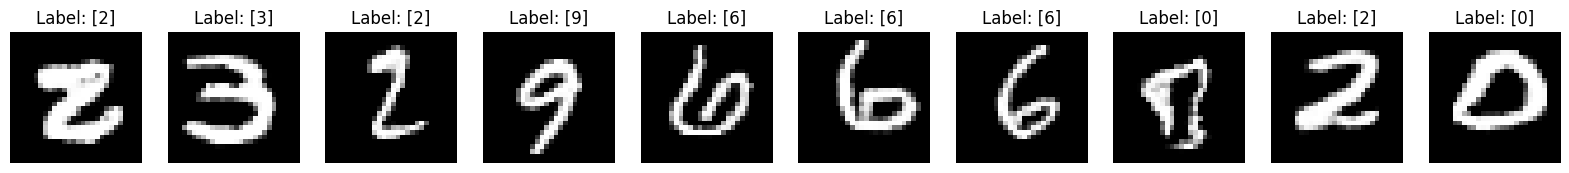

In [52]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset from the pickle file
input_path = '/content/drive/MyDrive/Colab Notebooks/cGAN-main/generated_mnist_dataset.pkl'
with open(input_path, 'rb') as f:
    dataset = pickle.load(f)

images = dataset['images']
labels = dataset['labels']

# Ensure images is a Numpy array for easy indexing
images = np.array(images)
labels = np.array(labels)

# Select 10 random images and labels
indices = np.random.choice(len(images), 10, replace=False)
selected_images = images[indices]
selected_labels = labels[indices]

# Display the 10 random images with labels
fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for ax, img, label in zip(axes, selected_images, selected_labels):
    ax.imshow(np.squeeze(img), cmap='gray')  # Use np.squeeze to remove single-dimensional entries from the shape of an array.
    ax.title.set_text(f'Label: {label}')
    ax.axis('off')

plt.show()


In [ ]:
# # Adjust shape if necessary (e.g., adding a channel dimension for grayscale images)
# # This step depends on how your generator model outputs images
# generated_images = generated_images.reshape((-1, 28, 28, 1))  # Example for MNIST

# # Ensure labels are in the desired format, if needed
# # For instance, you might want to convert labels to categorical (one-hot encoding)
# # This is optional and depends on how you plan to use the data


# Save model in HDF5 format

Only generator is essential for us

In [ ]:
gan.generator.save("cgan.h5")

# Load model in HDF5 format